## Agente con todas las caracteristicas anteriores y persistencia de conversaciones

### Aparte de este codigo necesitas tambien tener: 
1. la base de datos que dice leyes recursive.db
2. El archivo de categorias_sinonimos_bolivia.json
3. y si es necesario el codigo para segmentar y indexear los archivos

In [64]:
from pathlib import Path

base_dir = Path.cwd()
leyes_dir = base_dir / "leyes"  

# If leyes_dir doesn't exist, try going up one level
if not leyes_dir.exists():
    leyes_dir = base_dir.parent / "leyes"

Definir Embeddings y LLM

In [65]:
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()

embeddings_model = os.getenv("EMBEDDINGS_MODEL")
openai_model = os.getenv("LLM_MODEL")

embeddings = OpenAIEmbeddings(model=embeddings_model)

# Crear una instancia del modelo ChatOpenAI
llm = ChatOpenAI(model= openai_model, temperature=0.7)

Herramienta Recuperadora de Docs

In [66]:
from langchain_community.vectorstores import SQLiteVec
from langchain_core.tools import tool
import json
import re

numero_docs_recuperados: int  = 4

@tool(response_format="content_and_artifact")
def recuperarDocs(query: str):
    """Recupera documentos de la base de datos SQLite Leyes OpenAI con información de categorías."""
    
    db_path_str = str(base_dir / "Database/leyes OpenAI.db")

    vector_store = SQLiteVec(
        table="leyes",
        connection=None,
        embedding=embeddings,
        db_file=db_path_str,
    )   
    
    # Identify categories in the query
    with open(Path.cwd() / "categorias_sinonimos_bolivia.json", "r", encoding="utf-8") as f:
        synonyms = json.load(f)
    
    found_categories = []
    query_words = set(re.findall(r'\b\w+\b', query.lower()))
    
    for category, terms in synonyms.items():
        for term in terms:
            if term.lower() in query_words:
                found_categories.append(category)
                break
    
    # Add category metadata to enhance result context
    retrieved_docs = vector_store.similarity_search(query, k=numero_docs_recuperados)
    
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" 
         f"Categorías relacionadas: {', '.join(found_categories)}\n"
         f"Content: {doc.page_content}" )
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs
    
tools = [recuperarDocs]

Definimos el estado que será pasado entre objetos para guardar mensajes


In [67]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

""" Estado del agente para el almacenamiento de mensajes y resumen """
class AgentState(TypedDict):
    # El campo messages  es una lista de mensajes de tipo BaseMessage que seran siempre añadidos a la lista por el decorator add_messages
    messages: Annotated[Sequence[BaseMessage], add_messages]
    summary: str
    rewrite_count: int = 0

Definimos Edges (aristas) entre los nodos

In [68]:
from typing import  Literal
from langchain_core.messages import RemoveMessage, SystemMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langchain import hub

rewrite_limit = 1
max_messages_before_summarize = 5

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Se fija si los documentos recuperados son relevantes para la pregunta del usuario.
    Args:
        state (messages): El estado Actual del agente, que contiene los mensajes y el conteo de reescrituras.
    Returns:
        str: Un string indicando la accion de generar o reescribir.
    """
    print("---VERIFICAR RELEVANCIA---")
    
    rewrite_count = state.get("rewrite_count", 0)
    if  rewrite_count >= rewrite_limit:
        print(f"---LÍMITE DE REFORMULACIONES ALCANZADO ({rewrite_count}/{rewrite_limit})---")
        return "generate"

    class grade(BaseModel):
        """Clase usando validación de Pydantic para recibir la respuesta del LLM."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    llm_with_tool = llm.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""Eres un evaluador que determina la relevancia de un documento recuperado para una pregunta del usuario. \n 
        Aquí está el documento recuperado: \n {context} \n
        Aquí está la pregunta del usuario: {question} \n
        Si el documento contiene informacion para responder la pregunta de manera explicita calificar como relevante \n
        Da una puntuación binaria 'yes' o 'no' para indicar si el documento es relevante para la pregunta.""",
        input_variables=["context", "question"],
    )

    chain = prompt | llm_with_tool

    messages = state["messages"]
    
    last_message = messages[-1]
    docs = last_message.content

    # Obtenemos el mensaje cambiado a pregunta estandar
    question = messages[1].content

    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score
    
    if score == "yes":
        print("---DECISION: DOCUMENTOS RELEVANTES---")
        return "generate"
    else:
        print(f"---DECISION: DOCUMENTOS NO RELEVANTES (Intento {rewrite_count+1}/{rewrite_limit})---")
        print(score)
        return "rewrite"
    
def summarize_or_agent(state) -> Literal["summarize_and_reformulate", "agent"]:
    messages = state["messages"]
        
    if len(messages) >= max_messages_before_summarize:
        print(f"---LIMITE DE MENSAJES ALCANZADO ({len(messages)}/{max_messages_before_summarize})---")
        return "summarize_and_reformulate"
    
    return "agent"


Definimos los Nodos

In [ ]:
import json
from pathlib import Path
import re

def pre_rewrite(state):
    """
    Pre-procesamos la pregunta con talvez terminos coloquiales para estandarizar .
    Args:
        state (messages): EL estado actual del agente
    Returns:
        dict: La pregunta estandarizada
    """
    print("---PRE-REESCRIBIR PREGUNTA---")
    
    # Reseteamos el conteo de reescrituras a 0
    reset_rewrite_count = 0
    state["rewrite_count"] = reset_rewrite_count
    
    messages = state["messages"]
    question = messages[-1].content

    # Cargamos el json de sinonimos
    with open(Path.cwd() / "categorias_sinonimos_bolivia.json", "r", encoding="utf-8") as f:
        synonyms = json.load(f)

    # Creamos un diccionario de sinonimos a terminos estandar
    colloquial_to_standard = {}
    for category, terms in synonyms.items():
        standard_term = category.split(" / ")[0].lower()
        for term in terms:
            colloquial_to_standard[term.lower()] = standard_term

    # Reemplazamos los terminos coloquiales por los estandar
    words = re.findall(r'\b\w+\b', question)
    standardized_words = [
        colloquial_to_standard.get(word.lower(), word) for word in words
    ]
    standardized_question = " ".join(standardized_words)

    print(f"Pregunta original: {question}")
    print(f"Pregunta Estandarizada: {standardized_question}")

    return {"messages": [SystemMessage(content=standardized_question)]}


def summarize_and_reformulate(state):
    """
    Resumimos la conversación hasta el momento. Si ya existe un resumen, lo extendemos. Ademas Reformulamos la pregunta estandarizada gracias al resumen.
    Args:
        state (messages): El estado actual del agente
    Returns:
        dict: El estado con los mensajes eliminados y el resumen generado
    """
    print("---RESUMIR---")
    
    summary = state.get("summary", "")
    
    messages = state["messages"]
    standarized_question = messages[-1]
    
    if summary:
        summary_message = (
            f"Este es el resumen de la conversacion hasta ahora: \n{summary}\n"
            "Extiendelo manteniendo la brevedad tomando en cuenta los mensajes anteriores:"
        )
    else:
        summary_message = "Crea un resumen de 3 oraciones de la conversacion en previa:"
    
    messages = state["messages"] + [SystemMessage(content=summary_message)]
    response = llm.invoke(messages)
    new_summary = response.content
    
    reformulate_prompt = f""" 
        Usando el resumen como contexto\n
        {new_summary} \n
        Reformula la siguiente pregunta de manera concisa, sin mencionar a Bolivia:\n 
        {standarized_question.content} \n
    """ 
    reformulated_question = llm.invoke([SystemMessage(content=reformulate_prompt)])
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-1]]
    
    return {"summary": response.content, "messages": delete_messages + [reformulated_question]}

def agent(state):
    """
    Invocamos al agente para que verifique si se necesita usar la herramienta de recuperacion de informacion.
    Args:
        state (messages): El estado actual del agente
    Returns:
        dict: El estado con los mensajes y la respuesta del agente
    """
    print("---LLAMAR AL AGENTE---")
    messages = state["messages"]
    last_message = messages[-1]

    summary = state.get("summary", "")
    if summary:
        sys_msg=f"""
        Eres un asistente legal que responde preguntas sobre el reglamento de tránsito boliviano.\n
        Aquí está el resumen de la conversación hasta ahora:\n
        {summary}\n
        y esta es la pregunta:\n
        {last_message.content}\n
        solo en caso que no puedas responder la pregunta llama a la herramienta haciendo el query brevemente, no menciones a Bolivia.
        """
    else:
        sys_msg=f"""
        Eres un asistente legal que responde preguntas sobre el reglamento de tránsito boliviano. 
        Esta es la pregunta:
        {last_message.content} 
        si necesitas mas información usa la herramienta, haz el query breve, no menciones a Bolivia.
        """    
    system_message = SystemMessage(content=sys_msg)
    
    model = llm.bind_tools(tools)
    response = model.invoke([system_message])
    return {"messages": [response]}


def rewrite(state):
    """
    Reescribe la pregunta en caso que no se haya encontrado información relevante.
    Args:
        state (messages): El estado actual del agente

    Returns:
        dict: El estado con la pregunta reescrita y el conteo de reescrituras incrementado
    """

    print("---REESCRIBIR PREGUNTA---")
    messages = state["messages"]
    question = messages[1].content
    msg = [
        SystemMessage(content=f""" \n 
            Observa la entrada e intenta razonar sobre la intención / significado semántico subyacente. \n 
            Aquí está la pregunta inicial:
            \n ------- \n
            {question} 
            \n ------- \n
            Formula una pregunta breve y mejorada: """
        )
    ]

    new_count = state.get("rewrite_count", 0) + 1
    
    response = llm.invoke(msg)
    return {"messages": [response], "rewrite_count": new_count}


def generate(state):
    """
    Generar respuesta a la pregunta estandarizada usando la herramienta de recuperacion de informacion.
    Args:
        state (messages): El estado actual del agente
    Returns:
         dict: El estado actualizado con la respuesta generada
    """
    
    print("---GENERAR---")
    messages = state["messages"]
    
    question = messages[1].content
    last_message = messages[-1]

    docs = last_message.content
    
    template = """ Responde exclusivamente en español. \n
    Eres un asistente legal que puede responder preguntas sobre el reglamento de tránsito boliviano.\n
    Usa solamente información de la referencia para responder. \n
    En caso de que no encuentres la respuesta en la referencia, responde con "No tengo información sobre eso". \n
    En tu respuesta menciona el articulo que corresponda a tu respuesta y el titulo completo del documento \n

    Usa la siguiente información como referencia: \n
    {context}
    
    Responde a la siguiente pregunta: \n
    {question}

    Respuesta:"""
    custom_rag_prompt = PromptTemplate.from_template(template)

    rag_chain = custom_rag_prompt | llm | StrOutputParser()

    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [AIMessage(content=response)]}

Declaracion de Base de datos de Checkpoints

In [70]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = base_dir / "Database/checkpoints.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

Compilado del grafo

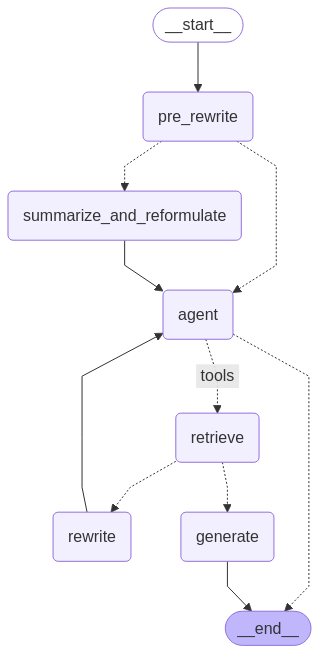

In [71]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

workflow = StateGraph(AgentState)

# Hacemos un nodo a la herramienta de recuperacion de documentos
retrieve = ToolNode([recuperarDocs])

workflow.add_node("pre_rewrite", pre_rewrite)  
workflow.add_node("summarize_and_reformulate", summarize_and_reformulate)  
workflow.add_node("agent", agent)  
workflow.add_node("retrieve", retrieve)  
workflow.add_node("rewrite", rewrite) 
workflow.add_node("generate", generate)

# Añadimos las aristas a los nodos del grafo
workflow.add_edge(START, "pre_rewrite")
workflow.add_conditional_edges(
    "pre_rewrite",
    summarize_or_agent, # summarize_or_agent es un decorator que añade la logica de si se necesita resumir o no
    {
        "summarize_and_reformulate": "summarize_and_reformulate",
        "agent": "agent",
    },
)
workflow.add_edge("summarize_and_reformulate", "agent")
workflow.add_conditional_edges(
    "agent",
    tools_condition, # tools_condition es un decorator que añade la logica de si se necesita usar la herramienta o no
    {
        "tools": "retrieve",
        END: END,
    },
)
workflow.add_conditional_edges(
    "retrieve",
    grade_documents, # grade_documents es un decorator que añade la logica de si se necesita reescribir o no
    {
        "generate": "generate",
        "rewrite": "rewrite",
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

graph = workflow.compile(checkpointer=memory)

# Creamos una imagen del grafo (OPCIONAL)
from IPython.display import Image, display
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

Generamos id al hilo y procedemos a preguntar

In [79]:
from langchain_core.messages import  HumanMessage
from langgraph.config import RunnableConfig
import uuid

thread_id = str(uuid.uuid4())
print(f"----NUEVA CONVERSACION CREADA CON ID: {thread_id} ----")

config: RunnableConfig = {"configurable": {"thread_id": thread_id}}

messages = [
    HumanMessage(content="¿Que pasa si atropellé a alguien?"),
]
output_messages = graph.invoke({"messages": messages}, config)
last_message = output_messages['messages'][-1]
last_message.pretty_print()

----NUEVA CONVERSACION CREADA CON ID: 1b67db67-4f75-4088-a426-5d78d6b0e202 ----
---PRE-REESCRIBIR PREGUNTA---
Pregunta original: ¿Que pasa si atropellé a alguien?
Pregunta Estandarizada: Que pasa si atropellé a alguien
---LLAMAR AL AGENTE---
---VERIFICAR RELEVANCIA---
---DECISION: DOCUMENTOS NO RELEVANTES (Intento 1/1)---
no
---REESCRIBIR PREGUNTA---
---LLAMAR AL AGENTE---
---VERIFICAR RELEVANCIA---
---LÍMITE DE REFORMULACIONES ALCANZADO (1/1)---
---GENERAR---
================================== Ai Message ==================================

Si atropellaste a alguien, el procedimiento depende de la gravedad del accidente. Según el Artículo 428° del documento "Bolivia: Reglamento del Código del Tránsito, 8 de junio de 1978", en casos de accidentes graves cuyo juzgamiento corresponde a los tribunales ordinarios, la División de Investigaciones del Tránsito procederá a levantar las diligencias de Policía Judicial y elevará un informe al Ministerio Público. 

En caso de accidentes leves, seg

In [80]:
messages = [
    HumanMessage(content="¿Y si escapo?"),
]
output_messages = graph.invoke({"messages": messages}, config)
last_message = output_messages['messages'][-1]
last_message.pretty_print()

---PRE-REESCRIBIR PREGUNTA---
Pregunta original: ¿Y si escapo?
Pregunta Estandarizada: Y si escapo
---LIMITE DE MENSAJES ALCANZADO (10/5)---
---RESUMIR---
---LLAMAR AL AGENTE---
---VERIFICAR RELEVANCIA---
---LÍMITE DE REFORMULACIONES ALCANZADO (1/1)---
---GENERAR---
================================== Ai Message ==================================

Si te das a la fuga después de estar implicado en un accidente, se presume tu culpabilidad según el Artículo 397° del "Reglamento del Código del Tránsito, 8 de junio de 1978". Esto significa que omitir presentar a la Policía del Tránsito el correspondiente informe te coloca en una situación de responsabilidad.
